<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Bayesian_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import numpy as np
import scipy.stats as st

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm

from agents.base_agent import Agent
from agents.bayesian_agent import BayesianAgent

## Bayesian iterative learning


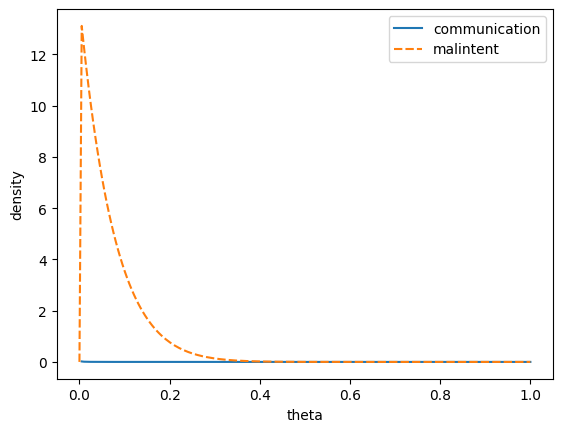

In [125]:
agents = [BayesianAgent(mu=0.01) for _ in range(10)]
for agent in agents:
    agent.set_cohort(agents)

# for example, the first agents parameters for the beta distribution to communicate with the second agent are:
_ = agents[0].plot_beta(agents[1], feature="both")

This distribution gets updated anytime the first agent interacts with the second. For example, if they repeatedly interact positively:

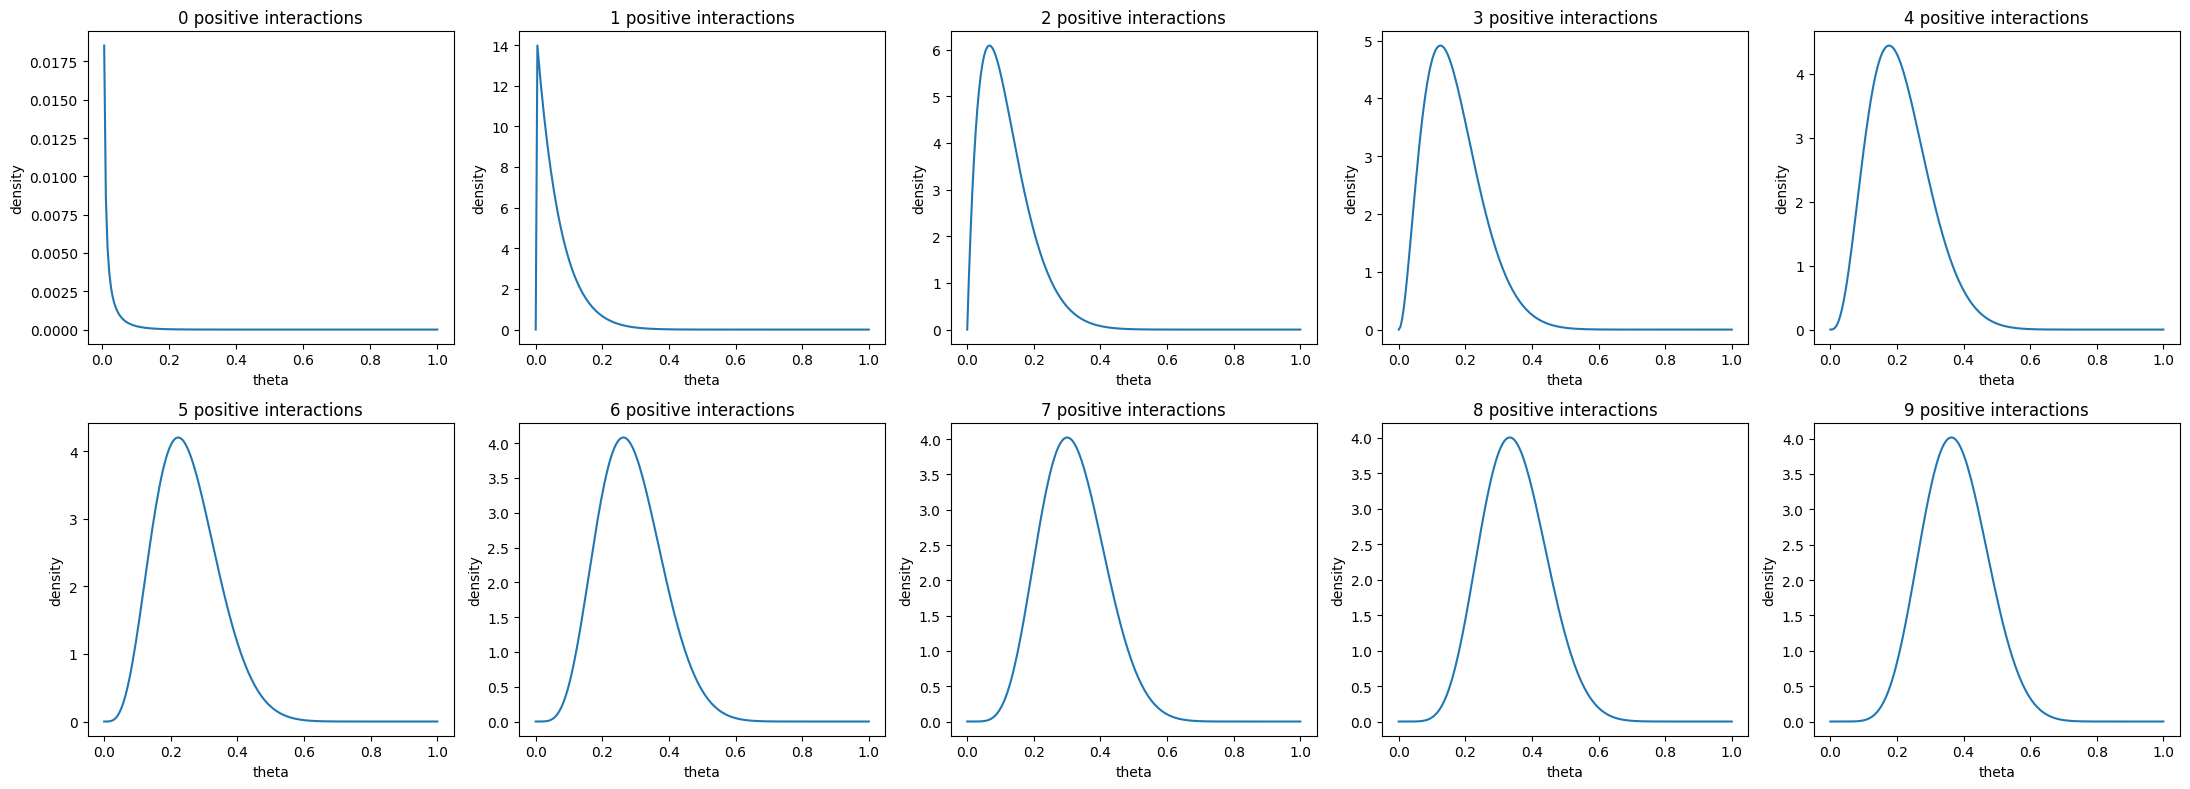

In [126]:
fig, ax = plt.subplots(2, 5, figsize = (22, 8))
beta_communicate = np.linspace(0,1,200)
for i in list(range(10)):
    a, b = agents[0].beta_communicate[agents[1]]
    _ = ax[int(i>4), i%5].plot(beta_communicate, st.beta.pdf(beta_communicate, a, b))
    _ = ax[int(i>4), i%5].set_xlabel("theta")
    _ = ax[int(i>4), i%5].set_ylabel("density")
    _ = ax[int(i>4), i%5].set_title(f"{i} positive interactions")
    agents[0].update_beta_communicate(agents[1], positive_outcome=True)
fig.tight_layout(w_pad=1, h_pad=1)

In [12]:
def reproduce(population: list[BayesianAgent], mu: float, size=1):
    offspring = []
    if len(population) > 2:
        total_rep = np.sum([agent.reputation for agent in population])
        repr_chances = td.Categorical(probs=torch.Tensor([agent.reputation/total_rep for agent in population])) # agents with higher reputation have higher chances of reproduction
        for _ in range(size):
            parent1 = population[int(repr_chances.sample())]
            while True:
                parent2 = population[int(repr_chances.sample())]
                if parent1 != parent2:
                    break
            offspring.append(BayesianAgent(mu, parents=(parent1, parent2)))
    return offspring

def simulate_bayesian_agents(num_food_opportunities: int, num_generations:int, population_size:int, gossip=False, mu=0.01, partitions=2, **class_variables):
    # adjust class variables if given:
    Agent.set_class_variables(**class_variables)
    # set up df to collect data:
    features = pd.DataFrame(columns=["communication", "malintent", "starvation", "final_reputation"])
    # initialize first generation
    current_gen = [BayesianAgent(mu) for _ in range(population_size)]
    # for saving data about bayesian updating
    partitions = [round(i/partitions*num_generations) for i in range(partitions+1)]
    partitions[0] = 1
    saved_generations = {} # generation: list of agents
    for gen in tqdm(range(1, (num_generations+1))):
        for agent in current_gen:
            agent.set_cohort(current_gen)
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(agent.cohort))
                # incorporate gossip (exchange of information)
                if gossip:
                    if len(agent.last_interaction) == 2:
                        other, pos_outcome = agent.last_interaction
                        recipient = np.random.choice(agent.cohort)
                        if other is not recipient:
                            recipient.incorporate_gossip(agent, other, pos_outcome)
            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]
        

        # record population level features/ statistics:
        communication, malintent, reputation = [],[], []
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
            reputation.append(agent.reputation)
        features.loc[len(features.index)] = [
            np.mean(communication) if len(current_gen) > 0 else None,
            np.mean(malintent) if len(current_gen) > 0 else None,
            (initial_generation_population_size-len(current_gen)) if len(current_gen) > 0 else None,
            np.mean(reputation)
            ]
        # save generation:
        if gen in partitions:
            saved_generations[gen] = [agent for agent in current_gen]

        # simulate reproduction with reputation:
        if gen < num_generations:
            current_gen = reproduce(current_gen, mu, size=population_size)
    return (saved_generations, features)

def plot_simulation_stats(simulation_stats):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    _ = sns.lineplot(data=simulation_stats.loc[:, simulation_stats.columns!="starvation"], ax=ax[0])
    _ = ax[0].set_xlabel("Generation")
    _ = ax[0].set_title("Features")
    _ = ax[0].set_ylim(0,17)
    _ = ax[1].scatter(simulation_stats.index, simulation_stats["starvation"], s=1)
    _ = ax[1].set_xlabel("Generation")
    _ = ax[1].set_title("Starvation")
    _ = ax[1].hlines(28, 0, len(simulation_stats), color="black", linestyles="dotted")
    _ = ax[1].legend(["starvation", "extinction threshold"])
    plt.show()

def plot_learned_distributions(gens: dict, figsize=(18,4)):
    fig, ax = plt.subplots(1, len(gens.keys()), figsize=figsize)
    for i, generation in enumerate(gens.items()):
        gen, agents = generation
        comm_matrix = pd.DataFrame(columns=[str(agent.id) for agent in agents])
        for agent in agents:
            for other in agents:
                comm_matrix.loc[agent.id, str(other.id)] = agent.beta_communicate[other][0]/sum(agent.beta_communicate[other]) if agent is not other else 0.
        comm_matrix = comm_matrix.apply(pd.to_numeric, errors='coerce')
        _ = sns.heatmap(comm_matrix, cmap="viridis", vmin=0, vmax=1, ax=ax[i])
        _ = ax[i].set_title(f"Learned Dists after {gen} Generations")
        _ = ax[i].set_xlabel("agent ids")
        _ = ax[i].set_ylabel("agent ids")
    plt.show()

## First Simulation with Bayesian Agents

100%|██████████| 200/200 [05:37<00:00,  1.69s/it]


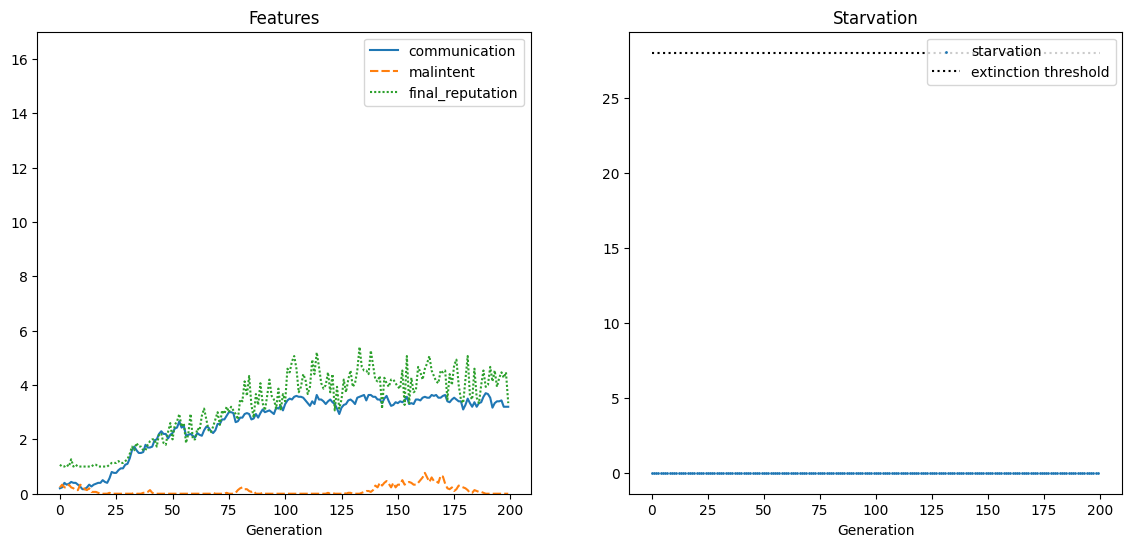

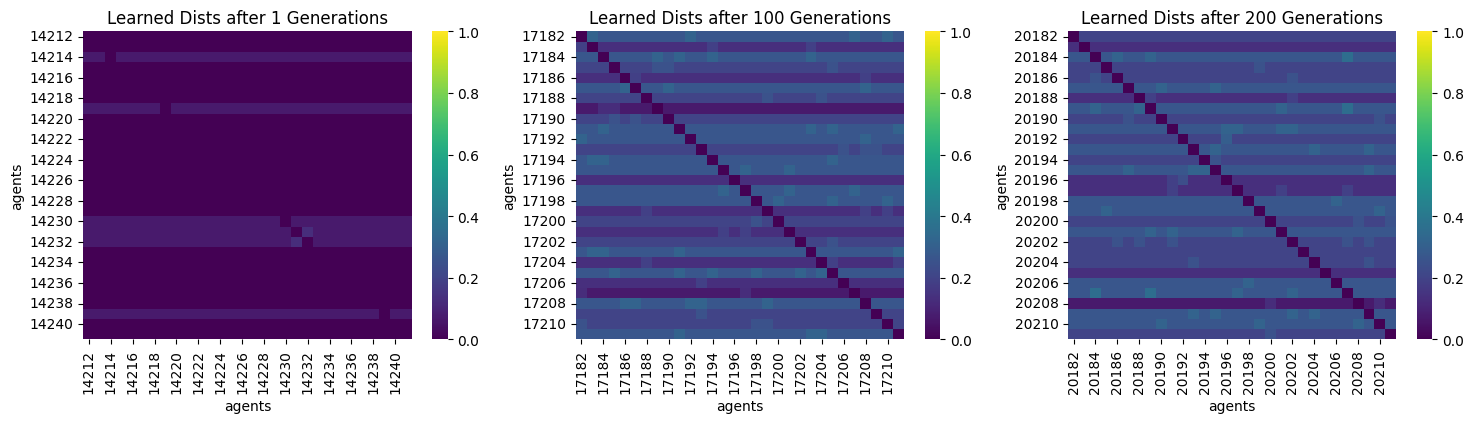

In [ ]:
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=30, num_generations=200, population_size=30, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen)

### Using Gossip

100%|██████████| 200/200 [06:23<00:00,  1.92s/it]


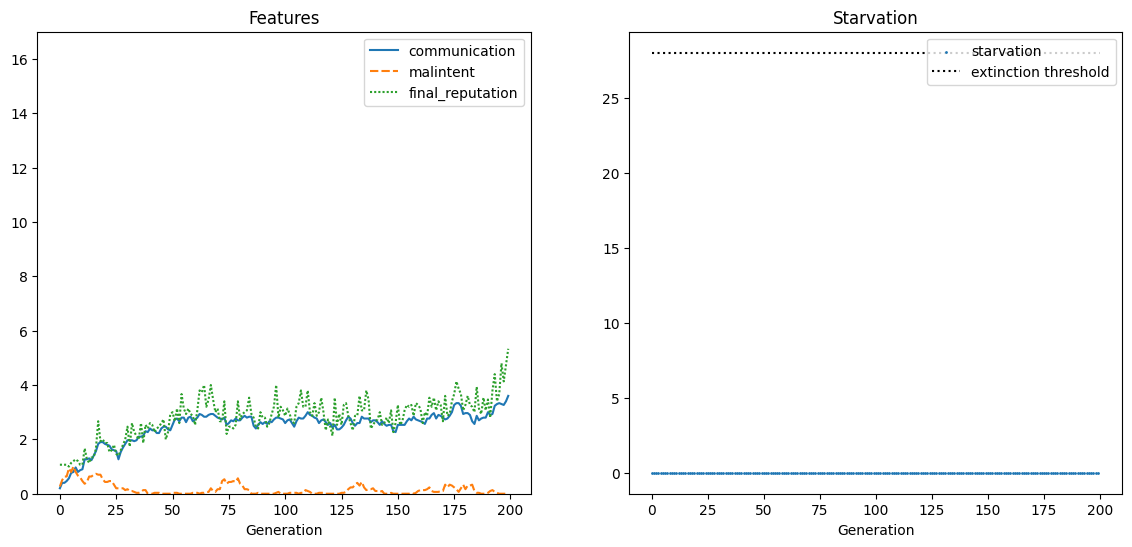

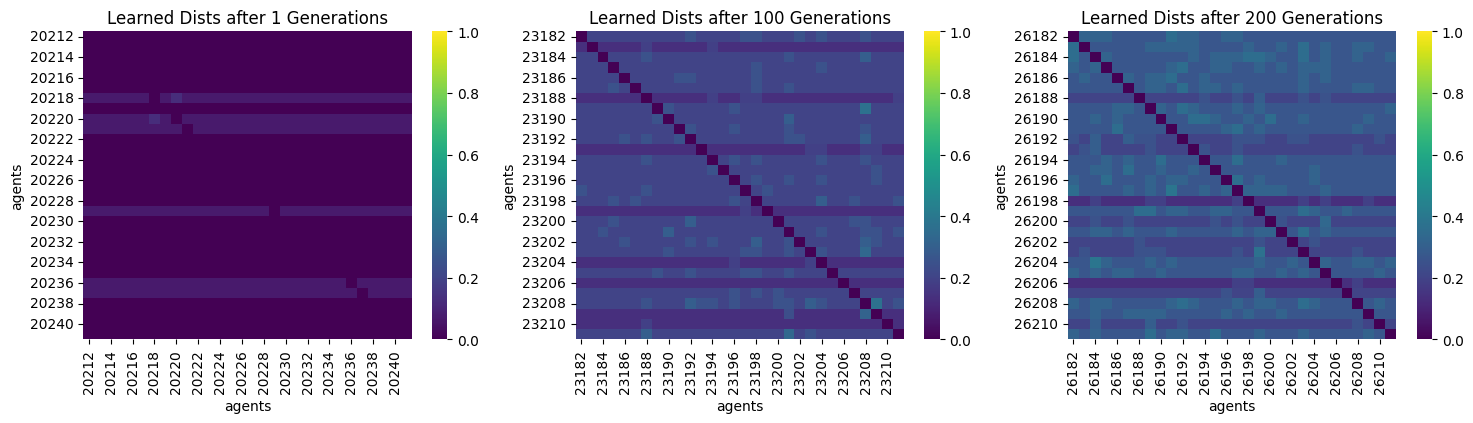

In [ ]:
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=30, num_generations=200, population_size=30, gossip=True, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [34:22<00:00,  2.06s/it]


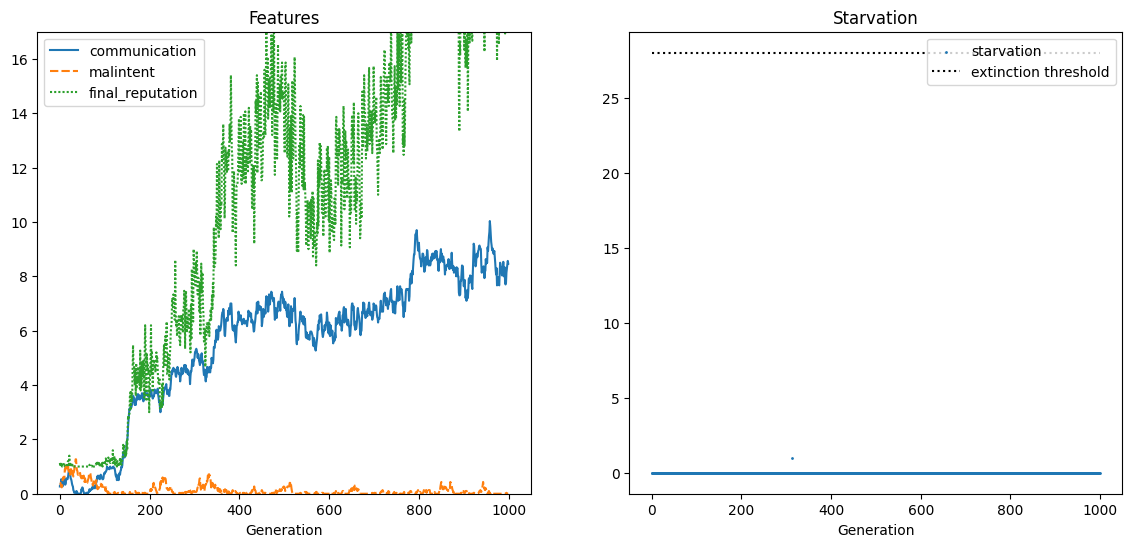

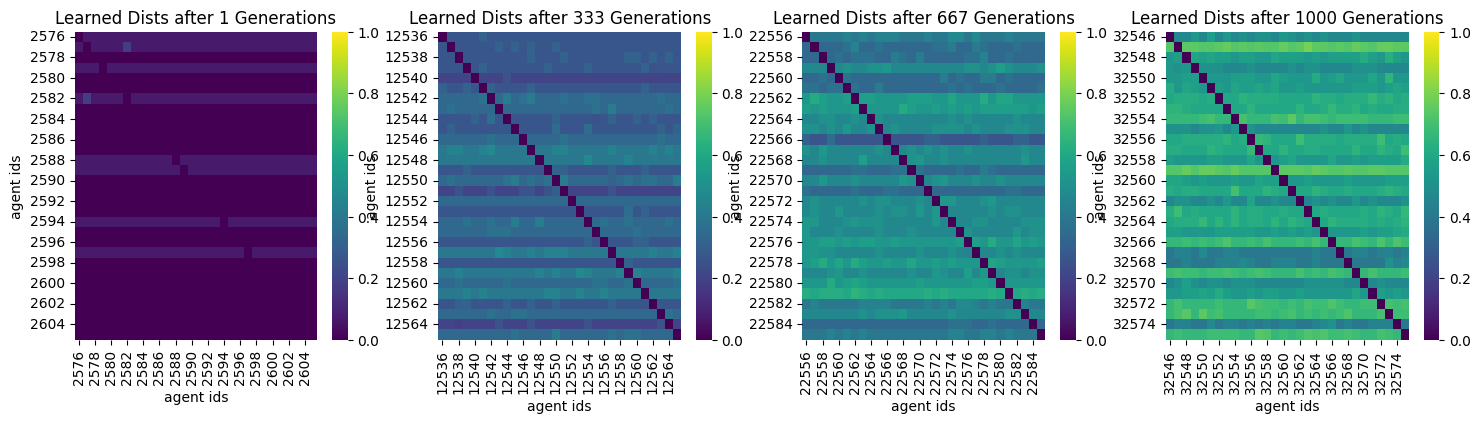

In [9]:
# longer simulation no gossip
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=30, num_generations=1000, population_size=30, partitions=3, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen)

100%|██████████| 1000/1000 [41:50<00:00,  2.51s/it]


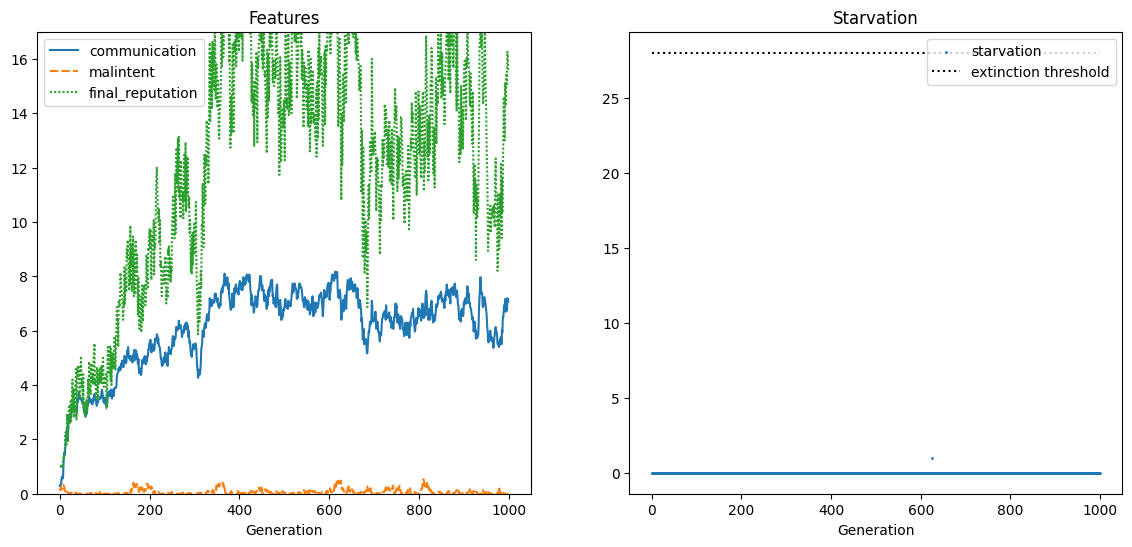

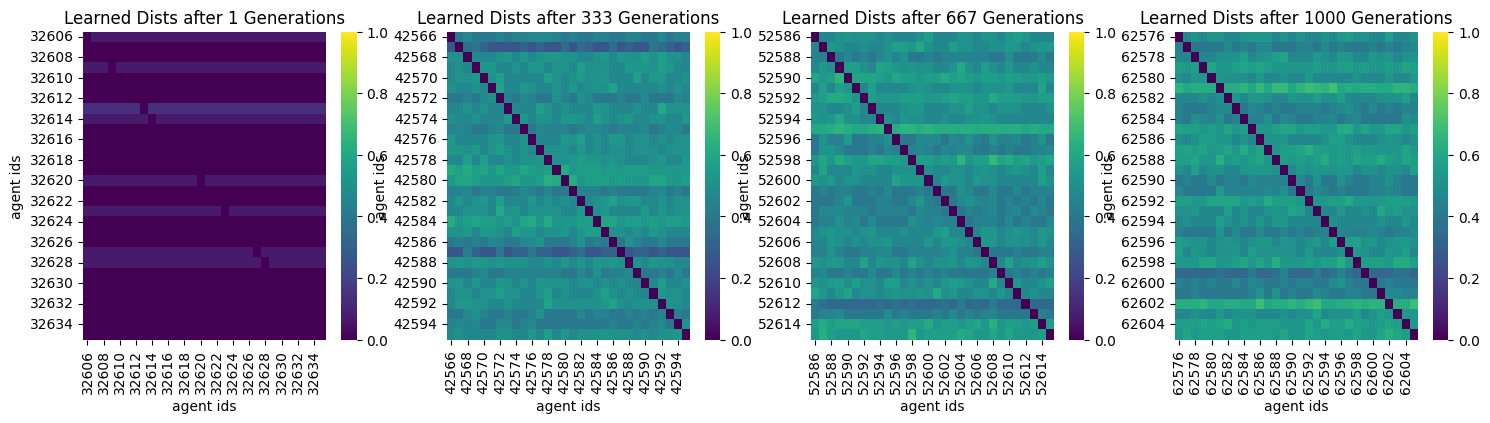

In [13]:
# longer simulation gossip
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=30, num_generations=1000, population_size=30, gossip=True, partitions=3, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen)

In [69]:
import networkx as nx

def plot_communication_network(gen: list[BayesianAgent]):
    G = nx.Graph()
    for agent in gen:
        G.add_node(agent)
    pos=nx.spring_layout(G)
    nx.layout
    nx.draw_networkx_nodes(G,pos,node_color='green',node_size=75)
    for agent in gen:
        for other in gen:
            if agent is not other:
                if agent.beta_communicate[other][0] > agent.communication:
                    weight=agent.beta_communicate[other][0]-agent.communication + agent.beta_communicate[other][1]-(len(agent.dna)/6-agent.communication)
                    if weight > 0:
                        G.add_edge(agent, other, weight=weight)
    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))
        #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        width = weight*len(gen)*5/sum(all_weights)
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width)
    plt.show()

100%|██████████| 1000/1000 [1:07:26<00:00,  4.05s/it]


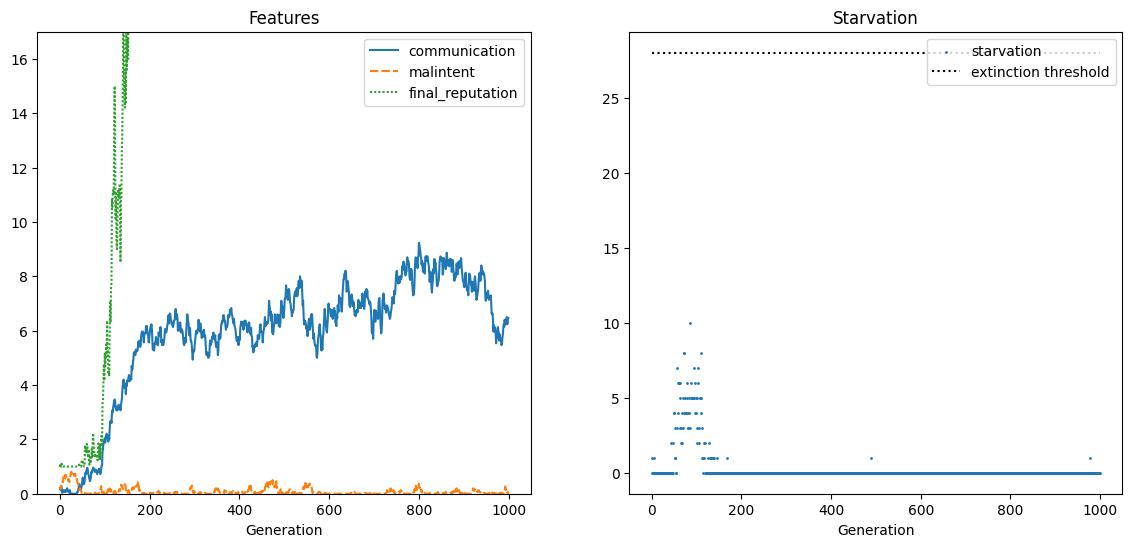

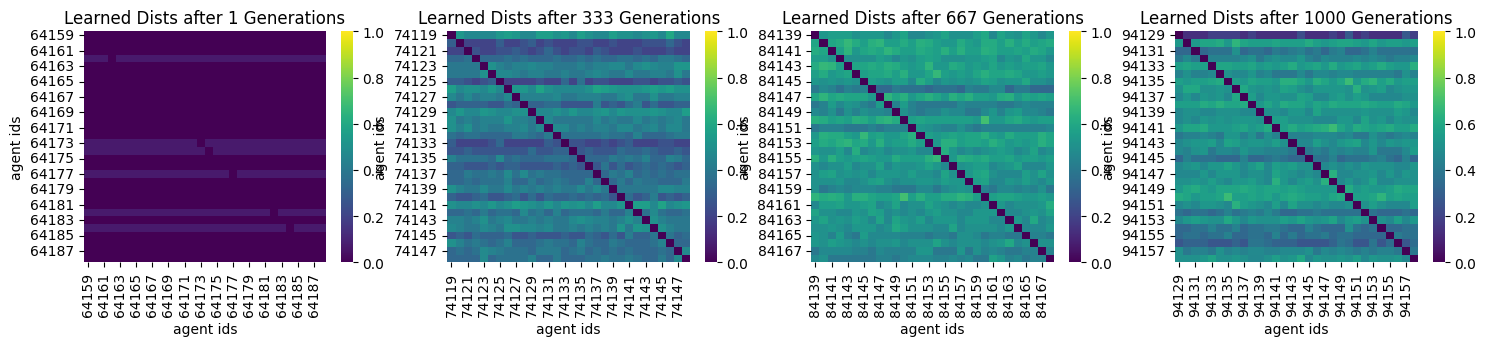

In [48]:
# longer simulation and more interactions no gossip
final_gen, sim_reputation = simulate_bayesian_agents(num_food_opportunities=100, num_generations=1000, population_size=30, partitions=3, food_decay = 1.65)
plot_simulation_stats(sim_reputation)
plot_learned_distributions(final_gen, figsize= (18,3))